# <center> OpenAI Gym and DQN <center>

### <center> Deep Reinforcement Learning Resource Allocation <center>

The goal of this notebook is to show how to implement a DQN in the for a resource allocation problem. If you want to know more about DQN, you can read:
- [Full gradient DQN reinforcement learning: A provably convergent scheme ](https://arxiv.org/pdf/2103.05981)
- Why DQN is bad: [Demystifying Approximate RL with epsilon-greedy Exploration: A Differential Inclusion View ](https://openreview.net/pdf?id=Ms1Zs8s7rg)




## Sommaire :

* [I. Basic of OpenAI Gym](#1)

* [II. Creation of an environment](#2)

* [III. Training a DQN Algorithm](#3)

* [IV. Exercice](#4)

## I. Basic of OpenAI Gym <a class="anchor" id="1"></a>



Install OpenAi Gym.

In [ ]:
pip install gym

Here a simple test of the environement using the CartPole environement.

In [ ]:
import gym
env = gym.make('CartPole-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        #env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated,

[-0.03313236  0.01688455 -0.02937806 -0.04279277]
[-0.03279467  0.21241519 -0.03023392 -0.34459808]
[-0.02854636  0.4079539  -0.03712588 -0.6466595 ]
[-0.02038728  0.60357296 -0.05005907 -0.9507984 ]
[-0.00831582  0.7993316  -0.06907504 -1.2587798 ]
[ 0.00767081  0.60515815 -0.09425063 -0.9885061 ]
[ 0.01977397  0.41141573 -0.11402076 -0.7268509 ]
[ 0.02800229  0.21803938 -0.12855777 -0.47211942]
[ 0.03236307  0.4147204  -0.13800016 -0.8023983 ]
[ 0.04065748  0.22173332 -0.15404813 -0.5561132 ]
[ 0.04509215  0.41864425 -0.16517039 -0.8930931 ]
[ 0.05346503  0.22610116 -0.18303226 -0.65654874]
[ 0.05798706  0.42323542 -0.19616322 -1.0008223 ]
Episode finished after 13 timesteps
[-0.03500262  0.00143521 -0.02950328  0.03343525]
[-0.03497391  0.19696756 -0.02883457 -0.26840833]
[-0.03103456  0.3924889  -0.03420274 -0.57004464]
[-0.02318478  0.5880734  -0.04560363 -0.8733034 ]
[-0.01142331  0.7837848  -0.0630697  -1.1799681 ]
[ 0.00425238  0.9796663  -0.08666906 -1.4917364 ]
[ 0.02384571  


The environment is a class implementing the interface of the Gym environment. It is in this class that we will define states, actions, and the <code>step</code> function that is used here. The function <code>step</code> is taking as input an action and will return 4 elements:

- An observation : an object specific to our environment that corresponds to the observation obtained from it
- A reward
- done : indicate whether or not the simulation is over.
- info : Extra info to debbug.

Please read a bit about the Gym environment by going through this link: https://www.gymlibrary.dev/content/basic_usage/

The action (resp. state) available to the agent are coded in a variable <code>action_space</code> (<code>observation_space</code>.). The classical spaces are <code>Discrete</code> abd <code>Box</code> :

- <code>Discrete(n)</code> = {0,1,...,n-1}
- <code>Box</code> is a box of size n, with a lower and upper terminal for each dimension.

The <code>render</code> function is used to display an "image" of the environment at time t.

Here is the shape of the interface corresponding to an OpenAi Gym environment:

```
import gym
from gym import spaces

class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, arg1, arg2, ...):
    super(CustomEnv, self).__init__()    
    
    # Define action and observation space
    # They must be gym.spaces objects    
    
    # Example when using discrete actions:
    self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)    
    
    # Example for using image as input:
    self.observation_space = spaces.Box(low=0, high=255, shape=
                    (HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)

  def step(self, action):
    # Execute one time step within the environment
    ...  
    
  def reset(self):
    # Reset the state of the environment to an initial state
    ...  
    
  def render(self, mode='human', close=False):
    # Render the environment to the screen
    ...

```

## II. Creation of an environment <a class="anchor" id="2"></a>

#### The machine replacement problem

A machine has possible states in $\{1,\ldots,S\}$ that represent how good it performs (the higher the better), state 1 can be consider as broken, state S as new. At each instant $k=0,\ldots$ either the machine is replaced (action $a=1$) or it is left unchanged (action $a=2$). We assume that

\begin{equation}
\begin{array}{ll}
P(s_{k+1}=S|a_k=1) &=1\\
P(s_{k+1}=s|s_k=s\_ ,a_k=2) &=(1-\theta)\delta_{s\_ ,s}+\theta \delta_{\max(1,s\_-1 ),s}.
\end{array}
\end{equation}

where $\delta_{a,b}=1$ if $a=b$ and $0$ otherwise.

When $a_k = 1$, we replace the machine, and so at next state the machine is new.
When $a_k = 2$, we do nothing, and so there is a probability of $1-\theta$ that we stay at the same state, a probability $\theta$ that our state decreases of one (the performance of the machine is worse), and if we are already at the worst state, there is a probability of one that we stay at this state.

At times $k=0,\ldots$, the cost of machine replacement is $c_k(s,a=1)=C + 1$, while if the machine is not replaced, there is still a cost given by $c_k(s,a=2)=(S-s)/(S-1)+ 1$, due to the loss of quantity/quality of the production of the machine when its state degrades. The discouned cost is given by $\gamma^kc_k(s,a)$.

We add 1 to all costs in order not to have a cost of 0 after repair, because if the cost is 0, as we do not have episodes for this environment, our q-agent won't continue learning (because we train it using a condition on the change of Q-Value and not on the number of iterations).

#### Setting up the environment

Download the important libraries

In [ ]:
import scipy
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import spaces

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Machine environment

In [ ]:
class Machine_env(gym.Env):

    metadata = {'render.modes': ['human']}


    def __init__(self, S, θ, C, max_iter = 100):
        super(Machine_env, self).__init__()

        self.action_space = spaces.Discrete(2)


        self.observation_space = spaces.Discrete(S)
        self.state = S-1
        self.new = S-1
        self.p_break = θ
        self.cost = C
        self.traj = [self.new]
        self.max_iter = max_iter


    def step(self, action):
        # Execute one time step within the environment

        if action == 0 :

            reward = -((self.new-self.state)/(self.new))

            breakdown = st.bernoulli.rvs(self.p_break,size=1)[0]
            if breakdown == 1:
                if self.state > 0:
                    self.state -= 1


        else:

            reward = -self.cost

            self.state = self.new


        observation = np.array([self.state])
        self.traj.append(observation)
        done = (len(self.traj)>=self.max_iter)
        info = {}

        return observation, reward-1, done, info




    def reset(self):
    # Reset the state of the environment to an initial state
        self.state = self.new
        plt.clf()
        self.traj = [self.new]
        return np.array([self.state])

    def render(self, mode='human', close=False):
    # Render the environment to the screen
        plt.clf()
        plt.xlabel("Time")
        plt.ylabel("Machine State")
        plt.scatter(range(len(self.traj)),self.traj)
        plt.show()
        plt.pause(0.01)
        print("State : ", self.state)

    def close(self):
        plt.close()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## III. Training a DQN Algorithm<a class="anchor" id="3"></a>




This code has been inspired by https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

## Required packages

In [ ]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# start the env
S_max = 100
env = Machine_env(S_max,0.5,1)

## Replay Memory

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classses:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.


In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now, let's define our model. But first, let's quickly recap what a DQN is.

## DQN algorithm

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. A lower $\gamma$ makes
rewards from the uncertain far future less important for our agent
than the ones in the near future that it can be fairly confident
about. It also encourages agents to collect reward closer in time
than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))\end{align}

To minimise this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss)_. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

### Q-network

Our model will be a feed forward  neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *expected return* of
taking each action given the current input.




In [ ]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Training

### Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the durations of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.

In [ ]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state = env.reset()
n_observations = 1

policy_net = DQN(1, n_actions).to(device)
target_net = DQN(1, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict()) #? copies the weights and biases from policy_net to target_net

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            # print("Policy greedy: ", policy_net(state))
            # print("Policy greedy :" , policy_net(state).argmax().view(1,1) )
            #return torch.argmax(policy_net(state))
            return policy_net(state).argmax().view(1,1)

    else:
      random_action = env.action_space.sample()
    #   print("Random action: ", random_action)
      return torch.tensor([[random_action]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def plot_trajectory_returns(trajectory_returns, show_result=False):
    plt.figure(1)
    trajectory_returns_t = torch.tensor(trajectory_returns, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Training Episodes')
    plt.ylabel('Trajectory Return')
    plt.plot(trajectory_returns_t.numpy())
    # Take 100 episode averages and plot them too
    # if len(trajectory_returns_t) >= 100:
    #     means = trajectory_returns_t.unfold(0, 100, 1).mean(1).view(-1)
    #     means = torch.cat((torch.zeros(99), means))
    #     plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())



<Figure size 640x480 with 0 Axes>

### Training loop

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By definition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network is updated at every step with a
[soft update](https://arxiv.org/pdf/1509.02971.pdf)_ controlled by
the hyperparameter ``TAU``, which was previously defined.




In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    # print(batch.action)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial ``state`` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set to 600 if a GPU is available, otherwise 50
episodes are scheduled so training does not take too long. However, 50
episodes is insufficient for to observe good performance on cartpole.
You should see the model constantly achieve 500 steps within 600 training
episodes. Training RL agents can be a noisy process, so restarting training
can produce better results if convergence is not observed.



In [ ]:
torch.cuda.is_available() # False

False

Complete


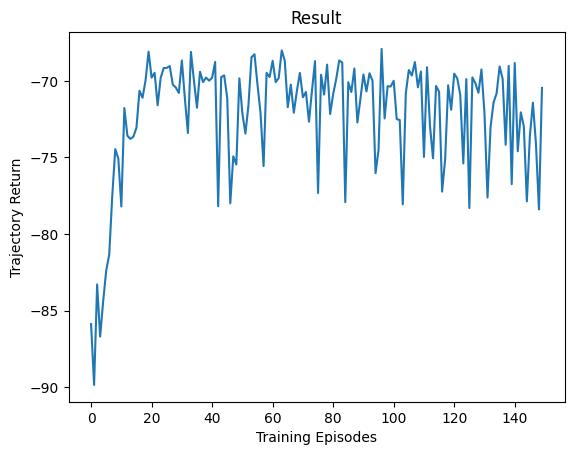

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 150 # 1000

trajectory_returns = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    traj_return = 0
    for t in count():
        # print("State : ", state)
        action = select_action(state)
        observation, reward, terminated, info = env.step(action.item())
        traj_return = traj_return + (GAMMA ** t ) * reward
        reward = torch.tensor([reward], device=device)
        done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            # episode_durations.append(t + 1)
            # plot_durations()
            trajectory_returns.append(traj_return)
            plot_trajectory_returns(trajectory_returns)
            break

print('Complete')
# plot_durations(show_result=True)
plot_trajectory_returns(trajectory_returns, show_result=True)
plt.ioff()
plt.show()


In [ ]:
# inputs_test = torch.tensor([float(i) for i in range(99)])
# print(inputs_test)
# for i in range(99):
#   print(policy_net(torch.tensor(inputs_test[i]))[0])

for i in range(99):
  Q = policy_net(torch.tensor([float(i)]))
  print(Q[0]-Q[1])

tensor(-1.2025, grad_fn=<SubBackward0>)
tensor(-1.3708, grad_fn=<SubBackward0>)
tensor(-1.5214, grad_fn=<SubBackward0>)
tensor(-1.5501, grad_fn=<SubBackward0>)
tensor(-1.5431, grad_fn=<SubBackward0>)
tensor(-1.5095, grad_fn=<SubBackward0>)
tensor(-1.4842, grad_fn=<SubBackward0>)
tensor(-1.4606, grad_fn=<SubBackward0>)
tensor(-1.4374, grad_fn=<SubBackward0>)
tensor(-1.3933, grad_fn=<SubBackward0>)
tensor(-1.3399, grad_fn=<SubBackward0>)
tensor(-1.2865, grad_fn=<SubBackward0>)
tensor(-1.2330, grad_fn=<SubBackward0>)
tensor(-1.1796, grad_fn=<SubBackward0>)
tensor(-1.1262, grad_fn=<SubBackward0>)
tensor(-1.0728, grad_fn=<SubBackward0>)
tensor(-1.0192, grad_fn=<SubBackward0>)
tensor(-0.9651, grad_fn=<SubBackward0>)
tensor(-0.9110, grad_fn=<SubBackward0>)
tensor(-0.8569, grad_fn=<SubBackward0>)
tensor(-0.8028, grad_fn=<SubBackward0>)
tensor(-0.7486, grad_fn=<SubBackward0>)
tensor(-0.6912, grad_fn=<SubBackward0>)
tensor(-0.6321, grad_fn=<SubBackward0>)
tensor(-0.5717, grad_fn=<SubBackward0>)


Documentation OpenAI Gym : https://www.gymlibrary.dev/content/basic_usage/

Part of this lab has been prepared by Pierre Charreaux, Théo Tembou Nzudie during their Project 3A.